In [3]:
import pandas as pd
import gsw
import matplotlib.pyplot as plt

# Define test files
test_files = {
    "Test 3": "2025-04-29T14-31-17_second_down.csv",
    "Test 5": "2025-05-28T12-07-17_clean_one.csv",
}

# Location for GSW
latitude = 61
longitude = -150

# Store frequencies
sampling_frequencies = {}

# Store DataFrames if needed
dfs = {}

for label, fname in test_files.items():
    df = pd.read_csv(fname)
    df["time"] = pd.to_datetime(df["time"])
    
    # filter out negative depths
    df = df[df["slowBRDepth"] >= 0]

    # --- GSW Calculations ---
    df["pressure"] = df["slowBRPres"] / 100
    df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)
    df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])
    df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

    # calculate sampling frequency
    time_deltas = df["time"].diff().dt.total_seconds()
    avg_interval = time_deltas.mean()
    sampling_frequency_hz = 1 / avg_interval if avg_interval else 0
    sampling_frequencies[label] = sampling_frequency_hz
    dfs[label] = df

    print(f"{label}: {sampling_frequency_hz:.2f} Hz")

Test 3: 4.98 Hz
Test 5: 4.98 Hz


Test 3: 4.98 Hz
Test 5: 4.98 Hz

Overall average sampling frequency: 4.98 Hz


C:\Users\sscop\AppData\Local\Temp\ipykernel_15612\3197509966.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


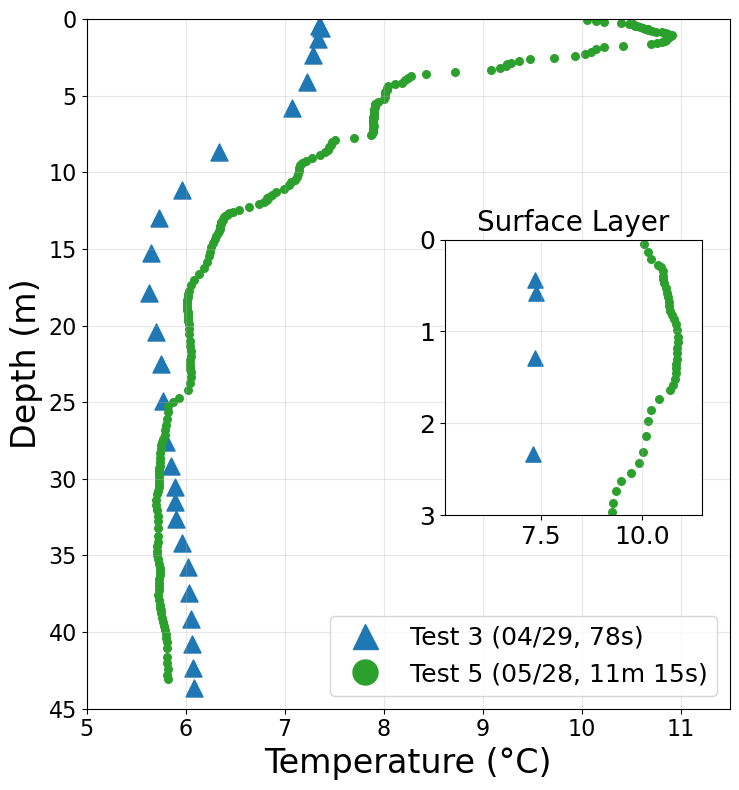

In [3]:
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines
import numpy as np

# Define test files
test_files = {
    "Test 3": "2025-04-29T14-31-17_second_down.csv",
    "Test 5": "2025-05-28T12-07-17_clean_one.csv",
}

# Colors and markers
color_map = {
    "Test 3": "tab:blue",
    "Test 5": "tab:green",
}
marker_map = {
    "Test 3": "^",  # circle
    "Test 5": "o",  # triangle up
}

# GSW location
latitude = 61
longitude = -150

# Store frequencies and data
sampling_frequencies = {}
dfs = {}

# --- Process data and calculate GSW variables ---
for label, fname in test_files.items():
    df = pd.read_csv(fname)
    df["time"] = pd.to_datetime(df["time"])
    df = df[df["slowBRDepth"] >= 0]

    df["pressure"] = df["slowBRPres"] / 100
    df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)
    df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])
    df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

    time_deltas = df["time"].diff().dt.total_seconds()
    avg_interval = time_deltas.mean()
    sampling_frequency_hz = 1 / avg_interval if avg_interval else 0
    sampling_frequencies[label] = sampling_frequency_hz
    dfs[label] = df

    print(f"{label}: {sampling_frequency_hz:.2f} Hz")

# overall average frequency
all_freqs = list(sampling_frequencies.values())
overall_avg = sum(all_freqs) / len(all_freqs)
print(f"\nOverall average sampling frequency: {overall_avg:.2f} Hz")

# --- Plotting ---
marker_size = 100
fig, ax = plt.subplots(figsize=(7.5, 8))

legend_labels = {}

for label, df in dfs.items():
    if label == "Test 3":
        df = df.iloc[30:]

    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")

    # Duration formatting
    duration_sec = int((df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds())
    if label == "Test 3":
        duration_str = f"{duration_sec}s"
    elif label == "Test 5":
        minutes = duration_sec // 60
        seconds = duration_sec % 60
        duration_str = f"{minutes}m {seconds}s"
    else:
        duration_str = f"{duration_sec:.1f}s"

    legend_label = f"{label} ({date_fmt}, {duration_str})"
    legend_labels[label] = legend_label

    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    # --- Main plot scatter ---
    size = 150 if marker_map[label] == "^" else 30

    ax.scatter(
        df_binned["fastBRTemp"],
        df_binned["slowBRDepth"],
        s=size,
        label=legend_label,
        color=color_map[label],
        marker=marker_map[label],
    )


# main plot settings
ax.set_xlabel("Temperature (°C)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)
ax.set_ylim(45, 0)
ax.set_xlim(5, 11.5)
ax.tick_params(labelsize=16)
ax.grid(alpha=0.3)

# Thicker legend markers with correct shapes
handles = [
    mlines.Line2D([], [], color=color_map[label], marker=marker_map[label],
                  linestyle='None', markersize=12)
    for label in test_files
]
ax.legend(handles, legend_labels.values(), fontsize=18, markerscale=1.5)

# inset
axins = inset_axes(
    ax, width="40%", height="40%", loc="lower right",
    bbox_to_anchor=(0, 0.24, 1, 1), bbox_transform=ax.transAxes, borderpad=2,
)

for label, df in dfs.items():
    if label == "Test 3":
        df = df.iloc[30:]

    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    # --- Inset plot scatter ---
    size = 120 if marker_map[label] == "^" else 30

    axins.scatter(
        df_binned["fastBRTemp"],
        df_binned["slowBRDepth"],
        s=size,
        color=color_map[label],
        marker=marker_map[label],
    )


axins.set_xlim(5.1, 11.5)
axins.set_ylim(3, 0)
axins.set_title("Surface Layer", fontsize=20)
axins.tick_params(labelsize=18)
axins.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("loweringSpeed_temp.jpg", dpi=600)
plt.show()


Test 3: 4.98 Hz
Test 5: 4.98 Hz

Overall average sampling frequency: 4.98 Hz


C:\Users\sscop\AppData\Local\Temp\ipykernel_24436\2637626688.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


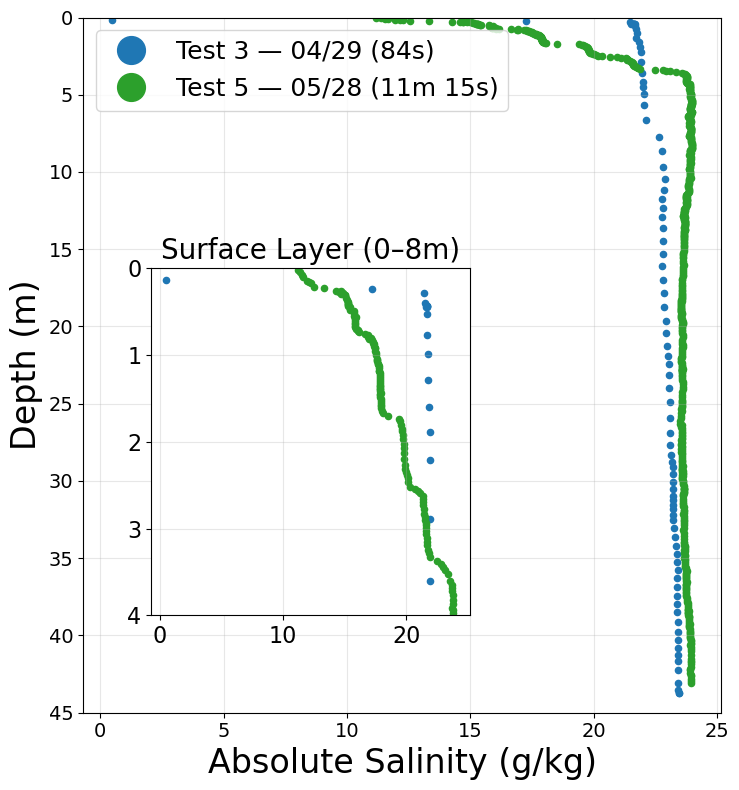

In [42]:
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines
import numpy as np

# Define test files
test_files = {
    "Test 3": "2025-04-29T14-31-17_second_down.csv",
    "Test 5": "2025-05-28T12-07-17_clean_one.csv",
}

# Fixed color mapping to make Test 5 green
color_map = {
    "Test 3": "tab:blue",
    "Test 5": "tab:green",
}

# GSW location
latitude = 61
longitude = -150

# Store frequencies and data
sampling_frequencies = {}
dfs = {}

# --- Process data and calculate GSW variables ---
for label, fname in test_files.items():
    df = pd.read_csv(fname)
    df["time"] = pd.to_datetime(df["time"])
    df = df[df["slowBRDepth"] >= 0]

    df["pressure"] = df["slowBRPres"] / 100
    df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)
    df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])
    df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

    time_deltas = df["time"].diff().dt.total_seconds()
    avg_interval = time_deltas.mean()
    sampling_frequency_hz = 1 / avg_interval if avg_interval else 0
    sampling_frequencies[label] = sampling_frequency_hz
    dfs[label] = df

    print(f"{label}: {sampling_frequency_hz:.2f} Hz")

# overall average frequency
all_freqs = list(sampling_frequencies.values())
overall_avg = sum(all_freqs) / len(all_freqs)
print(f"\nOverall average sampling frequency: {overall_avg:.2f} Hz")

# --- Salinity Plot ---
size = 20
linewidth = 3
fig, ax = plt.subplots(figsize=(7.5, 8))

legend_labels = {}

for label, df in dfs.items():
    # Date label
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")

    # Duration formatting
    duration_sec = int((df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds())
    if label == "Test 3":
        duration_str = f"{duration_sec}s"
    elif label == "Test 5":
        minutes = duration_sec // 60
        seconds = duration_sec % 60
        duration_str = f"{minutes}m {seconds}s"
    else:
        duration_str = f"{duration_sec:.1f}s"

    legend_label = f"{label} — {date_fmt} ({duration_str})"
    legend_labels[label] = legend_label

    # Bin average every 5 rows
    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    ax.scatter(df_binned["SA"], df_binned["slowBRDepth"],
               s=size, label=legend_label, color=color_map[label])

# main plot settings
ax.set_xlabel("Absolute Salinity (g/kg)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)
ax.set_ylim(45, 0)  
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)

# Legend with thicker markers
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h, l in zip(handles, labels):
    base_label = l.split(" —")[0] if " —" in l else l
    color = color_map.get(base_label, 'gray')
    new_handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10))
ax.legend(new_handles, labels, fontsize=18, markerscale=2)

# inset plot
axins = inset_axes(
    ax, width="50%", height="50%", loc="lower right",
    bbox_to_anchor=(-0.35, 0.1, 1, 1), bbox_transform=ax.transAxes, borderpad=2,
)

for label, df in dfs.items():
    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    axins.scatter(df_binned["SA"], df_binned["slowBRDepth"],
                  s=size, color=color_map[label])

axins.set_ylim(4, 0)  
axins.set_title("Surface Layer (0–8m)", fontsize=20)
axins.tick_params(labelsize=16)
axins.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("loweringSpeed_salt.jpg", dpi=600)
plt.show()


Test 3: 4.98 Hz
Test 5: 4.98 Hz

Estimated Lowering Speeds:
Test 3: 0.520 m/s
Test 5: 0.064 m/s

Overall average sampling frequency: 4.98 Hz


C:\Users\sscop\AppData\Local\Temp\ipykernel_6684\3443383838.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\sscop\AppData\Local\Temp\ipykernel_6684\3443383838.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


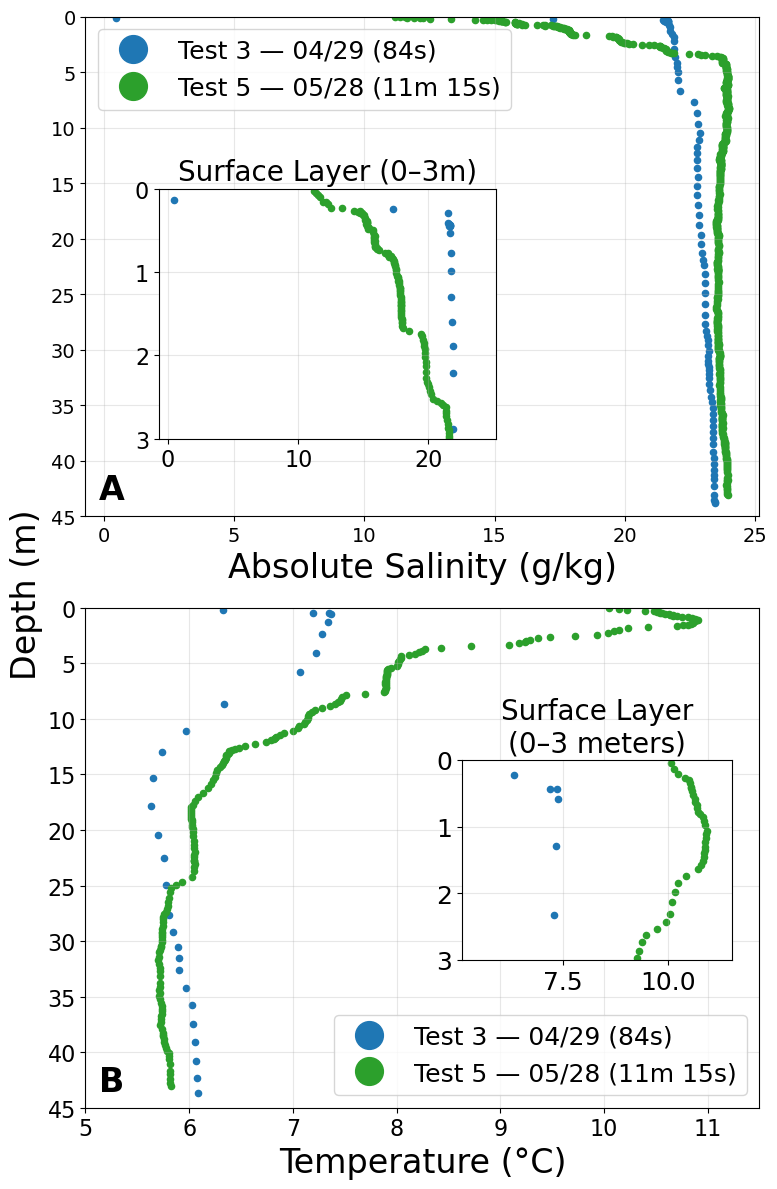

In [11]:
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines
import numpy as np

# Define test files
test_files = {
    "Test 3": "2025-04-29T14-31-17_second_down.csv",
    "Test 5": "2025-05-28T12-07-17_clean_one.csv",
}

# Fixed color mapping
color_map = {
    "Test 3": "tab:blue",
    "Test 5": "tab:green",
}

# GSW location
latitude = 61
longitude = -150

sampling_frequencies = {}
dfs = {}

# --- Load and process data ---
for label, fname in test_files.items():
    df = pd.read_csv(fname)  # Load the CSV file
    df["time"] = pd.to_datetime(df["time"])  # Convert time column to datetime
    df = df[df["slowBRDepth"] >= 0]  # Filter out negative depths

    df["pressure"] = df["slowBRPres"] / 100  # Convert pressure to dbar
    df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)  # Absolute Salinity
    df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])  # Conservative Temperature
    df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])  # Potential density anomaly

    time_deltas = df["time"].diff().dt.total_seconds()  # Time differences between samples
    avg_interval = time_deltas.mean()  # Average sampling interval in seconds
    sampling_frequency_hz = 1 / avg_interval if avg_interval else 0  # Sampling frequency (Hz)

    sampling_frequencies[label] = sampling_frequency_hz  # Store frequency
    dfs[label] = df  # Store processed DataFrame

    print(f"{label}: {sampling_frequency_hz:.2f} Hz")  # Print frequency result

print("\nEstimated Lowering Speeds:")
for label, df in dfs.items():
    depth_diff = df["slowBRDepth"].iloc[-1] - df["slowBRDepth"].iloc[0] # Get the depth change over the cast (final depth - initial depth)
    duration_sec = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds() # Compute the total time duration of the cast in seconds

    if duration_sec > 0: # Avoid division by zero and calculate lowering speed
        speed = depth_diff / duration_sec # Average lowering speed in meters per second (m/s)
        print(f"{label}: {speed:.3f} m/s")
    else:
        
        print(f"{label}: duration too short to compute speed.") # Handle edge case if timestamps are not valid or cast is too short

all_freqs = list(sampling_frequencies.values())
overall_avg = sum(all_freqs) / len(all_freqs)
print(f"\nOverall average sampling frequency: {overall_avg:.2f} Hz")

# --- Create combined figure ---
size = 20
linewidth = 3
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7.5, 12), sharey=True)
# fig.suptitle("Lowering Speed", fontsize=24, y=0.99)

# Add subplot labels (a) and (b)
ax1.text(0.02, 0.02, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='bottom', ha='left')
ax2.text(0.02, 0.02, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold', va='bottom', ha='left')

# --- Salinity subplot (Top) ---
for label, df in dfs.items():
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")

    duration_sec = int((df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds())
    if label == "Test 3":
        duration_str = f"{duration_sec}s"
    elif label == "Test 5":
        minutes = duration_sec // 60
        seconds = duration_sec % 60
        duration_str = f"{minutes}m {seconds}s"
    else:
        duration_str = f"{duration_sec:.1f}s"

    legend_label = f"{label} — {date_fmt} ({duration_str})"

    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    ax1.scatter(df_binned["SA"], df_binned["slowBRDepth"],
                s=size, label=legend_label, color=color_map[label])

ax1.set_xlabel("Absolute Salinity (g/kg)", fontsize=24)
ax1.set_ylim(45, 0)
ax1.tick_params(labelsize=14)
ax1.grid(alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
new_handles = [
    mlines.Line2D([], [], color=color_map[label.split(" —")[0]], marker='o',
                  linestyle='None', markersize=10)
    for label in labels
]
ax1.legend(new_handles, labels, fontsize=18, markerscale=2)

# Inset for salinity
axins1 = inset_axes(ax1, width="50%", height="50%", loc="lower right",
                    bbox_to_anchor=(-0.35, 0.1, 1, 1), bbox_transform=ax1.transAxes, borderpad=2)

for label, df in dfs.items():
    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    axins1.scatter(df_binned["SA"], df_binned["slowBRDepth"],
                   s=size, color=color_map[label])

axins1.set_ylim(3, 0)
axins1.set_title("Surface Layer (0–3m)", fontsize=20)
axins1.tick_params(labelsize=16)
axins1.grid(alpha=0.3)

# --- Temperature subplot (Bottom) ---
for label, df in dfs.items():
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")

    duration_sec = int((df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds())
    if label == "Test 3":
        duration_str = f"{duration_sec}s"
    elif label == "Test 5":
        minutes = duration_sec // 60
        seconds = duration_sec % 60
        duration_str = f"{minutes}m {seconds}s"
    else:
        duration_str = f"{duration_sec:.1f}s"

    legend_label = f"{label} — {date_fmt} ({duration_str})"

    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    ax2.scatter(df_binned["fastBRTemp"], df_binned["slowBRDepth"],
                s=size, label=legend_label, color=color_map[label])

ax2.set_xlabel("Temperature (°C)", fontsize=24)
ax2.set_xlim(5, 11.5)
ax2.set_ylim(45, 0)
ax2.tick_params(labelsize=16)
ax2.grid(alpha=0.3)

handles, labels = ax2.get_legend_handles_labels()
new_handles = [
    mlines.Line2D([], [], color=color_map[label.split(" —")[0]], marker='o',
                  linestyle='None', markersize=10)
    for label in labels
]
ax2.legend(new_handles, labels, fontsize=18, markerscale=2)

# Inset for temperature
axins2 = inset_axes(ax2, width="40%", height="40%", loc="lower right",
                    bbox_to_anchor=(0, 0.24, 1, 1), bbox_transform=ax2.transAxes, borderpad=2)

for label, df in dfs.items():
    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    axins2.scatter(df_binned["fastBRTemp"], df_binned["slowBRDepth"],
                   s=size, color=color_map[label])

axins2.set_xlim(5.1, 11.5)
axins2.set_ylim(3, 0)
axins2.set_title("Surface Layer\n(0–3 meters)", fontsize=20)
axins2.tick_params(labelsize=18)
axins2.grid(alpha=0.3)

plt.tight_layout()
fig.text(-0.03, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=24)

# Final layout
plt.tight_layout()
plt.savefig("loweringSpeed_combined.jpg", dpi=600, bbox_inches="tight")
plt.show()